In [ ]:
# ..... integrated - each sample and MN ..... #

In [2]:
library(Seurat)
library(SingleCellExperiment)
library(MetaNeighbor)

In [3]:
# load data
get_seurat_obj <- function(currstage1){
    
    sc1 = readRDS(paste0(currstage1, '_integrated_cca.rds'))

#     df1 = read.delim(paste0(currstage1, '_cluster_anno_Knight-Schrijver.csv'), sep = ',')
    df1 = read.delim(paste0(currstage1, '_Qiu_SHC_Monocle_clusters.csv'), sep = ',')
    
    ids = match(rownames(sc1@meta.data), df1$barcode)
    
#     sc1$metacell = df1$metacell[ids]
#     sc1$celltype = df1$consensus_type[ids]
#     sc1$cluster = df1$cluster[ids]
    
    sc1$celltype = df1$monocle_cluster[ids]
    sc1$celltype2 = df1$shc_cluster[ids]

    sc1$stage <- sc1$orig.ident
    sc1 <- sc1[,!is.na(sc1$celltype)]
    return(sc1)
}

In [54]:
# load individual sample files
stage1 = 'stage32'
sce1 = get_seurat_obj(stage1)

# get metadata
# cols = c('stage', 'sample', 'metacell', 'celltype', 'cluster')
cols = c('stage', 'sample', 'celltype', 'celltype2')
mtd0 = sce1@meta.data[,cols]

# make SCE object
sce = SingleCellExperiment(list(counts = sce1@assays$RNA@counts),
                           colData = DataFrame(mtd0))

options(warn = -1)
start.time <- Sys.time()
hvg = variableGenes(sce, exp_labels = sce$sample)

# defaults to top 95% of genes. May need to vary
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

# get top 2k hvgs
if(length(hvg)>2000){
    hvg <- sample(hvg, 2000, replace = F)
}

Time difference of 8.629778 secs

In [55]:
# MN scores
options(warn = -1)
aurocsall = MetaNeighborUS(var_genes = hvg, dat = sce, study_id = sce$sample, 
    cell_type = sce$celltype, fast_version = TRUE, one_vs_best = FALSE,
    symmetric_output = TRUE)

aurocs1v1 = MetaNeighborUS(var_genes = hvg, dat = sce, study_id = sce$sample, 
    cell_type = sce$celltype, fast_version = TRUE, one_vs_best = TRUE,
    symmetric_output = TRUE)

# save
# save(aurocs1v1, aurocsall, topdf, 
#      file = paste0(stage1, '_', stage2, '_metacell_MN.Rdata'))

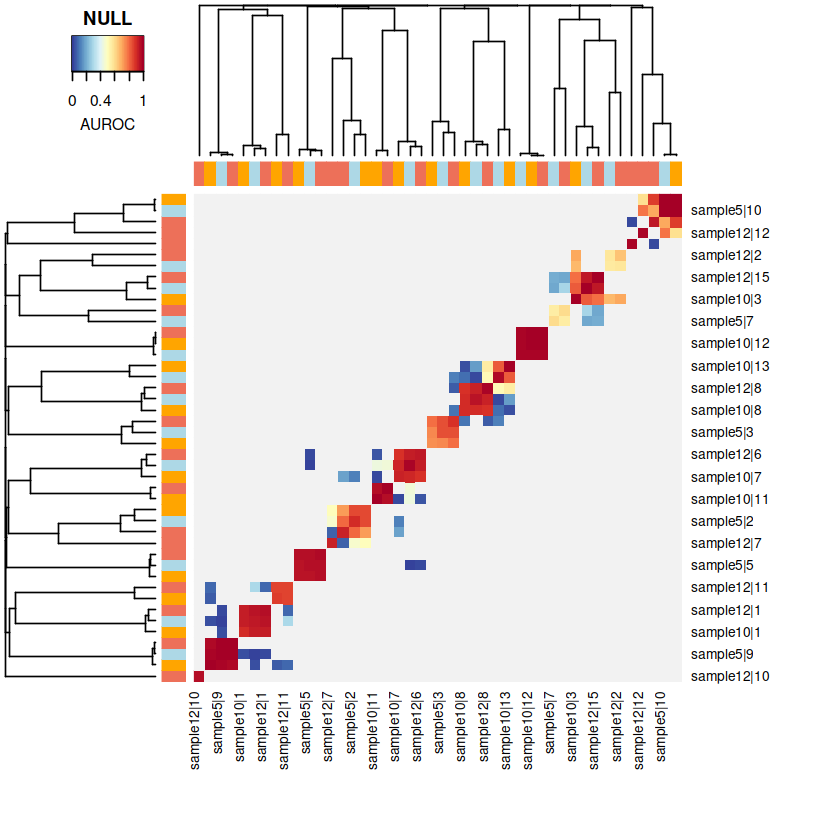

In [56]:
# plot heatmaps #
exps = sub('\\|.*', '', rownames(aurocsall))
reg2 = sort(unique(sce$sample))
regcols2 = c('orange', '#ed7059', 'lightblue')
cols2 = regcols2[match(exps, reg2)]

# png('aabbcc.png', width = 10, height = 10, res = 300, units = 'in')
plotHeatmap(aurocs1v1, ColSideColors = cols2, RowSideColors = cols2, margins = c(10,10))
# dev.off()

In [57]:
top_all = topHits(aurocsall, dat = sce, study_id = sce$sample, 
                cell_type = sce$celltype, threshold = 0.85)
dim(top_all)
head(top_all)

top_1v1 = topHits(aurocs1v1, dat = sce, study_id = sce$sample, 
                cell_type = sce$celltype, threshold = 0.85)

[1] 29  4

Study_ID|Celltype_1 Study_ID|Celltype_2 Mean_AUROC Match_type        
1 sample10|12         sample12|17         1          Reciprocal_top_hit
2 sample5|10          sample10|9          1          Reciprocal_top_hit
3 sample5|4           sample12|1          1          Reciprocal_top_hit
4 sample5|9           sample12|13         1          Reciprocal_top_hit
5 sample5|6           sample10|8          1          Reciprocal_top_hit
6 sample5|10          sample12|12         1          Above_0.85

In [58]:
# save MN scores
save(aurocsall, aurocs1v1, top_all, top_1v1, file = paste0(stage1, '_monocle_cluster_MN_scores.Rdata'))

In [32]:
# plot heatmaps #
exps = sub('\\|.*', '', rownames(aurocsall))
ctypes = sub('.*\\|', '', rownames(aurocsall))
ctypes2 = mtd0$celltype[match(ctypes, mtd0$cluster)]

subs2 = c('Endocardial', 'Immature_Cardiomyocytes', 'Cardiomyocytes', 'Smooth_Muscle_Cells',  
          'Myeloid_Immune_Cells', 'Pericytes_Stromal', 'Fibroblasts',
          'Endothelial_Venous', 'Endothelial_Capillaries', 'Neuronal_Cells')
subcol2 = c('#574e3c', '#f87cc3', '#d43035', '#e78b00',  
            '#cd7883', '#651f7e', '#358957',
            '#4d9ec3', '#84b023', '#4900e6')
reg2 = c('sample5', 'sample10', 'sample12')
regcols2 = c('orange', '#ed7059', 'lightblue')

cols1 = subcol2[match(ctypes2, subs2)]
cols2 = regcols2[match(exps, reg2)]

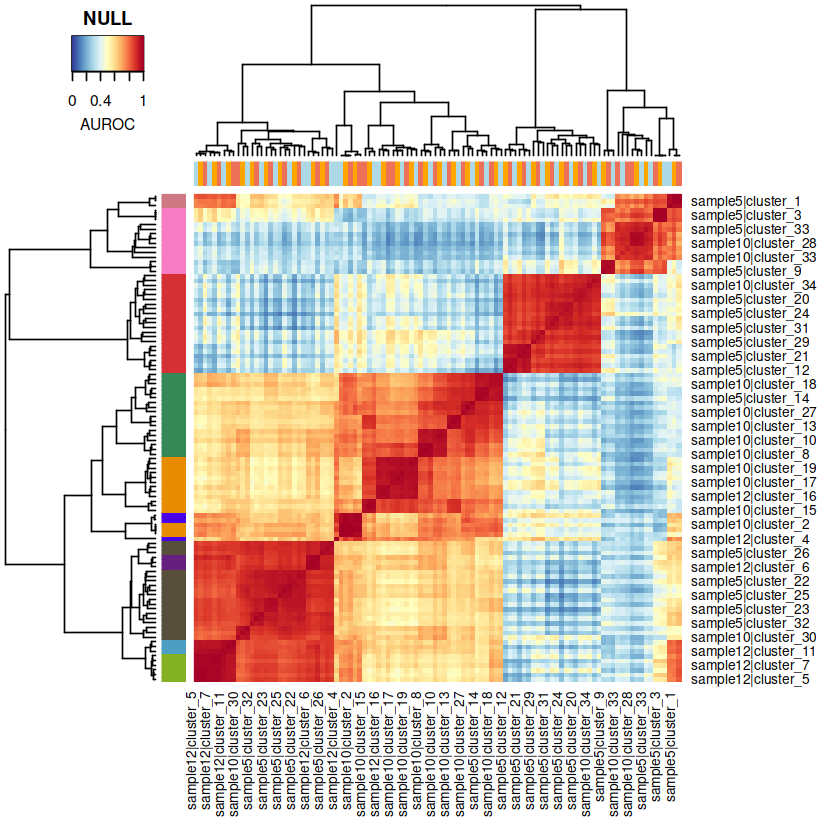

In [35]:
# png(paste0(stages[id], '_', samples[id], '_Mantri_MN.png'), width = 10, height = 10, res = 300, units = 'in')
# pdf('aa-stage32-cls-colors.pdf', width = 10, height = 10)
plotHeatmap(aurocsall, ColSideColors = cols2, RowSideColors = cols1, margins = c(10,10))
# dev.off()

In [23]:
length(unique(sce2$cluster))
table(sce2$celltype)

[1] 35


         Cardiomyocytes             Endocardial Endothelial_Capillaries 
                   3980                    2652                     761 
     Endothelial_Venous             Fibroblasts Immature_Cardiomyocytes 
                    136                    3449                    5120 
   Myeloid_Immune_Cells          Neuronal_Cells       Pericytes_Stromal 
                    134                     320                     225 
    Smooth_Muscle_Cells 
                   2783 